# Utqiagvik **Fall** Analysis - Significant Wave Height
- Bowhead whale hunting happens in fall (September/October/November) and is dependent on wind conditions, which drive waves.
- Notebook by Alice DuVivier (NCAR)
- Used to work with NPL 2025a, but it didn't have "windrose", so created new environment - analysis_windrose. Followed this guidance for modifying windrose to be prettier. https://medium.com/@benjamin.ganko/wind-roses-in-python-pretty-straight-forward-sort-of-d859e64c5fba
- January 2026

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import math

## Load Data

In [2]:
# set model to load - only CESM2-LE had wave data
model = 'cesm2le'

In [3]:
# set base directory
dir_base = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/'

In [4]:
# set path for files
dir_in = dir_base+'cesm2-le_utqiagvik/'

### Load model HS data
- WW3 calculated wave field on a 4x3deg grid. We're looking at only significant wave height from point nearest UTQ.
- Output is 6h instantaneous. We are only able to look at 1990-2099 and for 8 ensemble members
- Significant Wave height is the height of the top 1/3 of waves.

In [5]:
# set file and then load data
file_in = 'Utqiagvik_CESM2-LE_1990-2100_6H-HS.nc'

# load data
ds = xr.open_dataset(dir_in+file_in, decode_times=False)

In [6]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd-hh
# We know it's 6H data for 1990-09-01-2099-11-30

# create full range of dates at 6H frequency
dates = pd.date_range(start="1990-09-01", end="2099-12-31", freq="6h")
# now drop non autumn (SON) months
months_to_drop = [1,2,3,4,5,6,7,8,12]
mask = ~dates.month.isin(months_to_drop)
dates_sub = dates[mask]
print(dates_sub.shape)

# assign the time coordinate
ds['time'] = dates_sub

(40040,)


In [7]:
# keep just significant wave height field
data_model = ds.HS

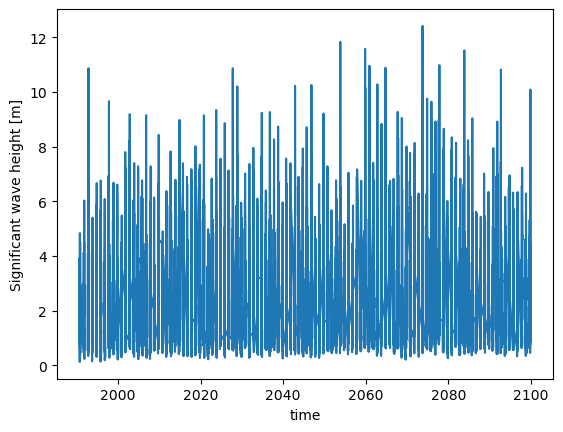

In [10]:
data_model.isel(member_id=1).plot()

## Process Fall Wave data - Model
- September, October, November only
- Just look at decadal histograms

In [11]:
# set year ranges for each decade

# 1995: 1993-1997
yy1_1 = 1993
yy1_2 = 1997
# 2045: 2043-2047
yy2_1 = 2043
yy2_2 = 2047
# 2095: 2093-2097
yy3_1 = 2093
yy3_2 = 2097

In [12]:
# get some dimensions

# total ensemble members - got this earlier
nens = len(ds.member_id)
print(nens)

# years from 1990-2100
years_model = np.arange(1990,2100,1)
nyrs = len(years_model)
print(nyrs)

# days are all days in SON
ndays = 30 + 31 + 30

# get total number of data points per year for all ensembles and all months at 6H (4x/day) timestep
times_tot = ndays*nens*4
print(times_tot)

8
110
2912


In [13]:
# Get data in yearly chunks
data_model = ds.HS

# preallocate arrays
data_array = np.zeros([nyrs,times_tot])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # get fall months only
    temp2 = temp1.isel(time=temp1.time.dt.month.isin([9,10,11]))
    # make 1d and put into the new array
    temp3 = temp2.stack(all=("member_id","time"))
    # put into new array
    data_array[index,:] = temp3

# convert the numpy arrays to xarrays for easier plotting
hs_fall = xr.DataArray(data_array,dims=('years','N'))
hs_fall['years'] = years_model

In [15]:
# subset data by the three decades and stack so that all data is in one dimension
data_sub = hs_fall

# decade 1
ws_dec1 = data_sub.where((data_sub.years >= yy1_1)&(data_sub.years <= yy1_2),drop=True).stack(npts=("years","N"))
# decade 2
ws_dec2 = data_sub.where((data_sub.years >= yy2_1)&(data_sub.years <= yy2_2),drop=True).stack(npts=("years","N"))
# decade 3
ws_dec3 = data_sub.where((data_sub.years >= yy3_1)&(data_sub.years <= yy3_2),drop=True).stack(npts=("years","N"))

## Plots

In [16]:
# set an output directory for figures
dir_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/utqiagvik_analysis/version_5/'

In [17]:
# set colors 
if model == 'cesm2le':
    c1 = 'royalblue'
    c2 = 'lightskyblue'
    lab = 'CESM2-LE'

In [33]:
# set number of bins 
n_bins = 32  # roughly 1m/s bins

### Timeseries and Histogram

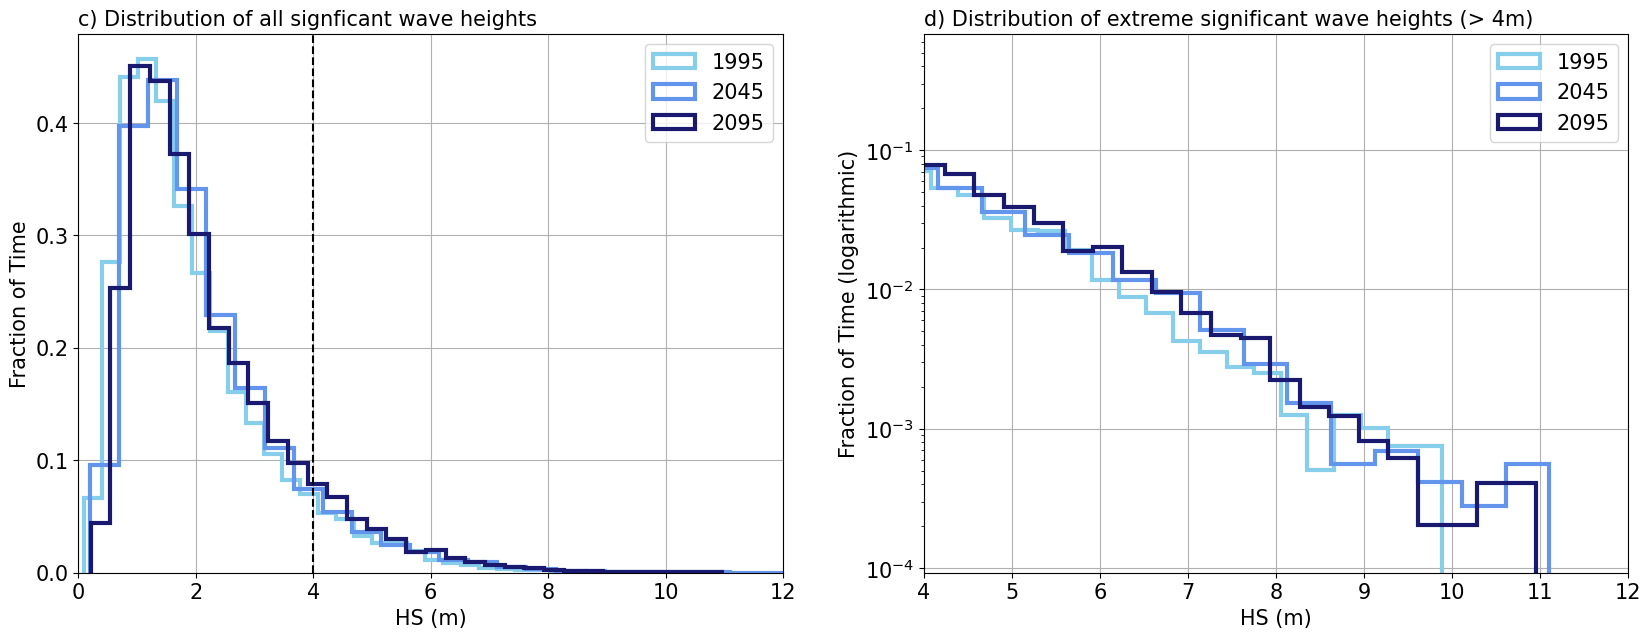

In [39]:
# create figure
fout = 'fig_6_utq_fall_wave_histogram_'+model

fig = plt.figure(figsize=(20,7))

# Make subplot - note it's nrow x ncol x index (starting upper left) - 3 rows x 2 columns
### Plot 1  - WS Histogram ###
ax = fig.add_subplot(1,2,1)
# first decade
ax.hist(ws_dec1, n_bins, color='skyblue', label='1995', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec2, n_bins, color='cornflowerblue', label='2045', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec3, n_bins, color='midnightblue', label='2095', density=True, histtype='step',linewidth=3, stacked=True, fill=False)
# add vertical line at 4m
plt.axvline(x=4, color='black', linestyle='--')
# modify plot
plt.title('c) Distribution of all signficant wave heights',loc='left',fontsize=15)
plt.xlabel('HS (m)',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim([0,12])
plt.ylabel('Fraction of Time',fontsize=15)
plt.yticks(fontsize=15)
#plt.ylim([0,0.12])
plt.grid()
plt.legend(loc='upper right', fontsize=15, ncol=1)

### Plot 2  - WS Histogram - Tail ###
ax = fig.add_subplot(1,2,2)
# first decade
ax.hist(ws_dec1, n_bins, color='skyblue', label='1995', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec2, n_bins, color='cornflowerblue', label='2045', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec3, n_bins, color='midnightblue', label='2095', density=True, histtype='step',linewidth=3, stacked=True, fill=False)
# modify plot
plt.title('d) Distribution of extreme significant wave heights (> 4m)',loc='left',fontsize=15)
plt.xlabel('HS (m)',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim([4,12])
plt.ylabel('Fraction of Time (logarithmic)',fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.grid()
plt.legend(loc='upper right', fontsize=15, ncol=1)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)